In [ ]:
data = open('input.txt', 'r').read()

chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

In [ ]:
pointer = 0
seq_len = 20

In [ ]:
inputs = ([char_to_idx[ch] 
           for ch in data[pointer: pointer + seq_len]])
targets = ([char_to_idx[ch] 
            for ch in data[pointer + 1: pointer + seq_len + 1]])

In [ ]:
inputs

In [ ]:
targets

In [ ]:
def sequence_to_model_input(sequence, vocab_size):
    x = {}
    for t in range(len(sequence)):
        x[t] = np.zeros((1, vocab_size))
        x[t][0, inputs[t]] = 1
    return x

In [ ]:
t = sequence_to_model_input(inputs, 62)

Model will output a 62 x 1 output. We _want_ it to output 0s for everything, but 1s for the correct target.

# Model definition

In [1]:
def softmax(x):
    shiftx = x - np.max(x)
    
    exp = np.exp(shiftx)
    
    sum_exp = np.sum(np.exp(shiftx), axis=1)
    new_matrix = exp / sum_exp[:, np.newaxis]
    return new_matrix

## Loss functions

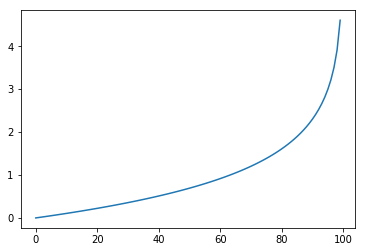

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([-np.log(1-x) for x in np.arange(0, 1, 0.01)])


In [7]:
y = np.array([[0,0,0,1,0], [0,0,1,0,0]])
pred = np.array([[0.1,0.2,0.3,0.2,0.1], [0.1,0.2,0.3,0.2,0.1]])

cross_entropy_deriv(pred, y)

array([[ 1.11111111,  1.25      ,  1.42857143, -5.        ,  1.11111111],
       [ 1.11111111,  1.25      , -3.33333333,  1.25      ,  1.11111111]])

In [6]:
def mean_square_error(prediction, y):
    return 0.5 * (prediction - y) ** 2

def cross_entropy(prediction, y):
    return np.array([-yi * np.log(predi) - (1-yi) * np.log(1-predi) for yi, predi in zip(y, prediction)])

def cross_entropy_deriv(prediction, y):
    return np.array([-yi / predi + (1-yi) / (1-predi) for yi, predi in zip(y, prediction)])

TODO: break batches up into individual words!

In [8]:
a = np.array([[]])
b = np.array([[1,2]])
np.append(a, b)
# c = np.array([3,4])
# a.append(b)
# a.append(c)
# a

array([1., 2.])

In [90]:
class LSTM_Model:
    '''
    An LSTM model with one LSTM layer that feeds data through it and generates an output.
    '''
    def __init__(self, sequence_length, vocab_size, hidden_size, learning_rate):
        '''
        Initialize list of nodes of length the sequence length
        List the vocab size and the hidden size 
        Initialize the params
        '''
        self.nodes = [LSTM_Node(hidden_size, vocab_size) for x in range(sequence_length)]
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.start_H = np.zeros(hidden_size)
        self.start_C = np.zeros(hidden_size)
        self.params = LSTM_Params(hidden_size, vocab_size)
        self.learning_rate = learning_rate

        
    def forward(self, x_batch, first_iter=False):

        batch_size = x_batch.shape[0]
        if first_iter:
            h_in = np.zeros((1, self.hidden_size))
            c_in = np.zeros((1, self.hidden_size))
        else:
            h_in = self.nodes[0].H_out
            c_in = self.nodes[0].C_out
        x_batch_out = np.array([[]])
        for i, node in enumerate(self.nodes):
            x_in = np.array(x_batch[i], ndmin=2)

            x_out, h_in, c_in = node.forward(x_in, h_in, c_in, self.params)

            if x_batch_out.shape[1] == 0:
                x_batch_out = np.append(x_batch_out, x_out, axis=1)
            else:
                x_batch_out = np.append(x_batch_out, x_out, axis=0)
                
        return x_batch_out
    
    def loss(self, prediction, y_batch):
        '''
        Return a gradient: how much our prediction influences how much we "missed" by.
        '''
        return cross_entropy(prediction, y_batch)

    
    def loss_gradient(self, prediction, y_batch):
        '''
        Return a gradient: how much our prediction influences how much we "missed" by.
        '''
        return cross_entropy_deriv(prediction, y_batch)
            
    def backward(self, loss_grad):
        '''
        Implements the "Backpropagation Through Time" algorithm.
        For each step in the sequence T moving backwards, backpropagate through some number
        K nodes
        
        '''
        # Initialize h_grad and c_grad
        # Initialize x_in, h_in, c_in, run em through
#         batch_size = loss_grad.shape[0]
        
        H_grad = np.zeros((1, self.hidden_size))
        C_grad = np.zeros((1, self.hidden_size))
        Y_grad = loss_grad
        
        T = self.sequence_length - 1
        K = 20 # BPTT length
        
        # BPTT
        num_iterations = T - K

#         for n in range(num_iterations):
        for t in range(T, T-K, -1):
#             import pdb; pdb.set_trace()
            Y_grad_in = np.array(Y_grad[T-t], ndmin=2)
            Y_grad_out, H_grad, C_grad = \
                self.nodes[T-t].backward(Y_grad_in, H_grad, C_grad, self.params)
                    
        return 


    def single_step(self, x_seq, y_seq, first_iter):
        prediction = self.forward(x_seq, first_iter=first_iter)
        p_softmax = softmax(prediction)
        loss_gradient = self.loss_gradient(p_softmax, y_seq)

#         import pdb; pdb.set_trace()
        self.backward(loss_gradient)
        self.params.update_params(self.learning_rate)
        self.params.clear_gradients()        

        
    def loss_batch(self, x, y):
        prediction = self.forward(x, first_iter=False)
        p_softmax = softmax(prediction)
        return np.sum(self.loss(p_softmax, y))

In [91]:
class LSTM_Node:
    '''
    An LSTM Node that takes in input and generates output. 
    Has a size of its hidden layers and a vocabulary size it expects.
    '''
    def __init__(self, hidden_size, vocab_size):
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
    def forward(self, X_input, H_input, C_input, LSTM_params):

        self.Z = np.column_stack((X_input, H_input))

        # Step 2
        self.F_int = np.dot(self.Z, LSTM_params.W_F)
        self.F = sigmoid(self.F_int)

        # Step 3
        self.I_int = np.dot(self.Z, LSTM_params.W_I)
        self.I = sigmoid(self.I_int)

        # Step 4
        self.C_prop_int = np.dot(self.Z, LSTM_params.W_C)
        self.C_prop = tanh(self.C_prop_int)

        # Step 5 
        self.C_out = self.F * C_input + self.I * self.C_prop

        # Step 6
        self.O_int = np.dot(self.Z, LSTM_params.W_O)
        self.O = sigmoid(self.O_int)

        # Step 7
        self.C_act = tanh(self.C_out)
        self.H_out = self.O * self.C_act

        # Step 8
        self.X_out = np.dot(self.H_out, LSTM_params.W_V)

        return self.X_out, self.H_out, self.C_out


    def backward(self, Y_grad, H_grad, C_grad, LSTM_params):
        # Initialize the gradient for the words and the hidden layers:
        self.Z_diff = np.zeros_like(self.Z)
        
        # 2
        LSTM_params.W_V_diff += np.dot(self.H_out.T, Y_grad)

        # 3
        self.H_diff = np.dot(Y_grad, LSTM_params.W_V_diff.T)
        self.H_diff += H_grad

        # 4
        self.O_diff = self.H_diff * self.C_act

        # 4.5
        self.O_int_diff = sigmoid(self.O, deriv=True) * self.O
        
        # 5
        LSTM_params.W_O_diff += np.dot(self.Z.T, self.O_int_diff)
        self.Z_diff = np.dot(self.O_int_diff, LSTM_params.W_O.T)
        
        # 6
        self.C_diff = C_grad
        self.C_diff += self.H_diff * self.O * tanh(self.C_act, deriv=True)

        # 7
        self.C_prop_diff = self.C_diff * self.I

        # 7.5
        self.C_prop_int_diff = tanh(self.C_prop, deriv = True) * self.C_prop_diff

        # 8
        LSTM_params.W_C_diff += np.dot(self.Z.T, self.C_prop_int_diff)
        self.Z_diff += np.dot(self.C_prop_int, LSTM_params.W_C.T)
        
        # 9
        self.I_diff = self.C_diff * self.C_prop

        # 9.5
        self.I_int_diff = sigmoid(self.I, deriv=True) * self.I_diff

        # 10
        LSTM_params.W_I_diff += np.dot(self.Z.T, self.I_int_diff)
        self.Z_diff += np.dot(self.I_int_diff, LSTM_params.W_I.T)
        
        # 11
        self.F_diff = self.C_diff * self.C_out

        # 11.5
        self.F_int_diff = sigmoid(self.F, deriv=True) * self.F_diff

        # 12
        LSTM_params.W_F_diff += np.dot(self.Z.T, self.F_int_diff)        
        self.Z_diff += np.dot(self.F_int_diff, LSTM_params.W_F.T)
        
        # 13
        C_grad = self.F * self.C_diff

        # 14
        X_grad = self.Z_diff[:, :self.vocab_size]
        H_grad = self.Z_diff[:, self.vocab_size:,]        

        return X_grad, H_grad, C_grad

In [92]:
a = [1,2,3]
np.clip(a, -0.5, 0.5, out=np.array(a))

array([0, 0, 0])

In [93]:
from numpy import linalg as LA

class LSTM_Params:
    
    def __init__(self, hidden_size, vocab_size):
        self.stack_size = hidden_size + vocab_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.W_F = np.random.normal(size=(self.stack_size, self.hidden_size), loc=0, scale=0.1)
        self.W_I = np.random.normal(size=(self.stack_size, self.hidden_size), loc=0, scale=0.1)
        self.W_C = np.random.normal(size=(self.stack_size, self.hidden_size), loc=0, scale=0.1)
        self.W_O = np.random.normal(size=(self.stack_size, self.hidden_size), loc=0, scale=0.1)
        self.W_V = np.random.normal(size=(self.hidden_size, self.vocab_size), loc=0, scale=0.1)

    def clear_gradients(self):
        self.W_F
        
    def clip_gradients(self):
        self.W_F_diff = np.clip(self.W_F_diff, -1, 1)
        self.W_I_diff = np.clip(self.W_I_diff, -1, 1)
        self.W_C_diff = np.clip(self.W_C_diff, -1, 1)
        self.W_O_diff = np.clip(self.W_O_diff, -1, 1)
        self.W_V_diff = np.clip(self.W_V_diff, -1, 1)        

        
    def update_params(self, learning_rate):
        self.clip_gradients()
        self.W_F -= learning_rate * self.W_F_diff
        self.W_I -= learning_rate * self.W_I_diff
        self.W_C -= learning_rate * self.W_C_diff
        self.W_O -= learning_rate * self.W_O_diff
        self.W_V -= learning_rate * self.W_V_diff

# Activations

In [94]:
def sigmoid(x, deriv=False):
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + np.exp(-x))

def tanh(x, deriv=False):
    if deriv:
        return 1 - x * x
    else:
        return np.tanh(x)

# Initialization

## Data

In [95]:
class Character_generator:
    
    def __init__(self, text_data, model):
        self.data = text_data
        self.model = model
        self.chars = list(set(data))
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_to_char = {i:ch for i,ch in enumerate(self.chars)}
        
        
    def generate_sequences(self, start_pos, seq_length):
        input_sequence = ([self.char_to_idx[ch] 
                           for ch in self.data[start_pos:start_pos + seq_length]])
        target_sequence = ([self.char_to_idx[ch] 
                            for ch in self.data[start_pos+1:start_pos + seq_length+1]])
        return input_sequence, target_sequence

    def sequence_to_model_input(self, sequence, vocab_size):
        out_batch = np.zeros((len(sequence), vocab_size))
        for i, el in enumerate(sequence):
            out_batch[i, el] = 1        
        return out_batch
    
    def generate_batch(self, start_pos):
        input_sequence, target_sequence = self.generate_sequences(start_pos, self.model.sequence_length)
        return self.sequence_to_model_input(input_sequence, self.vocab_size), \
            self.sequence_to_model_input(target_sequence, self.vocab_size) 
    
    def train(self, steps, check_every):
        start_pos = 0
        iterations = 0
        while iterations < steps:
            
            x_batch, y_batch = self.generate_batch(start_pos)
            first_iter = True if iterations == 0 else False
            self.model.single_step(x_batch, y_batch, first_iter)
            if iterations % check_every == 0:
                print("Loss", self.model.loss_batch(x_batch, y_batch))
                print(iterations)
            
            start_pos += self.model.sequence_length
            iterations += 1
            if start_pos + self.model.sequence_length > len(data):
                start_pos = 0


In [96]:
len(data) // 20

4999

In [97]:
np.seterr(all="raise")

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [98]:
data = open('input.txt', 'r').read()
mod = LSTM_Model(sequence_length=20, vocab_size=62, hidden_size=100, learning_rate=0.01)
character_generator = Character_generator(data, mod)
character_generator.train(10000, check_every=1000)

Loss 102.04147078591829
0
Loss 102.36886783682459
1000
Loss 102.35129719393359
2000
Loss 102.37662478089648
3000
Loss 102.3380308470633
4000
Loss 102.37473811781393
5000
Loss 102.0211819028246
6000
Loss 102.20791163702413
7000
Loss 102.39789625275345
8000
Loss 102.08138166870896
9000


In [49]:
np.max(character_generator.model.params.W_I)

45.10750961208381

TODO: Implement AdaGrad

Investigate exploding values

Forget Stanford CS231: reproduce the results from the `numpy_LSTM` notebook.

# Gradient clipping